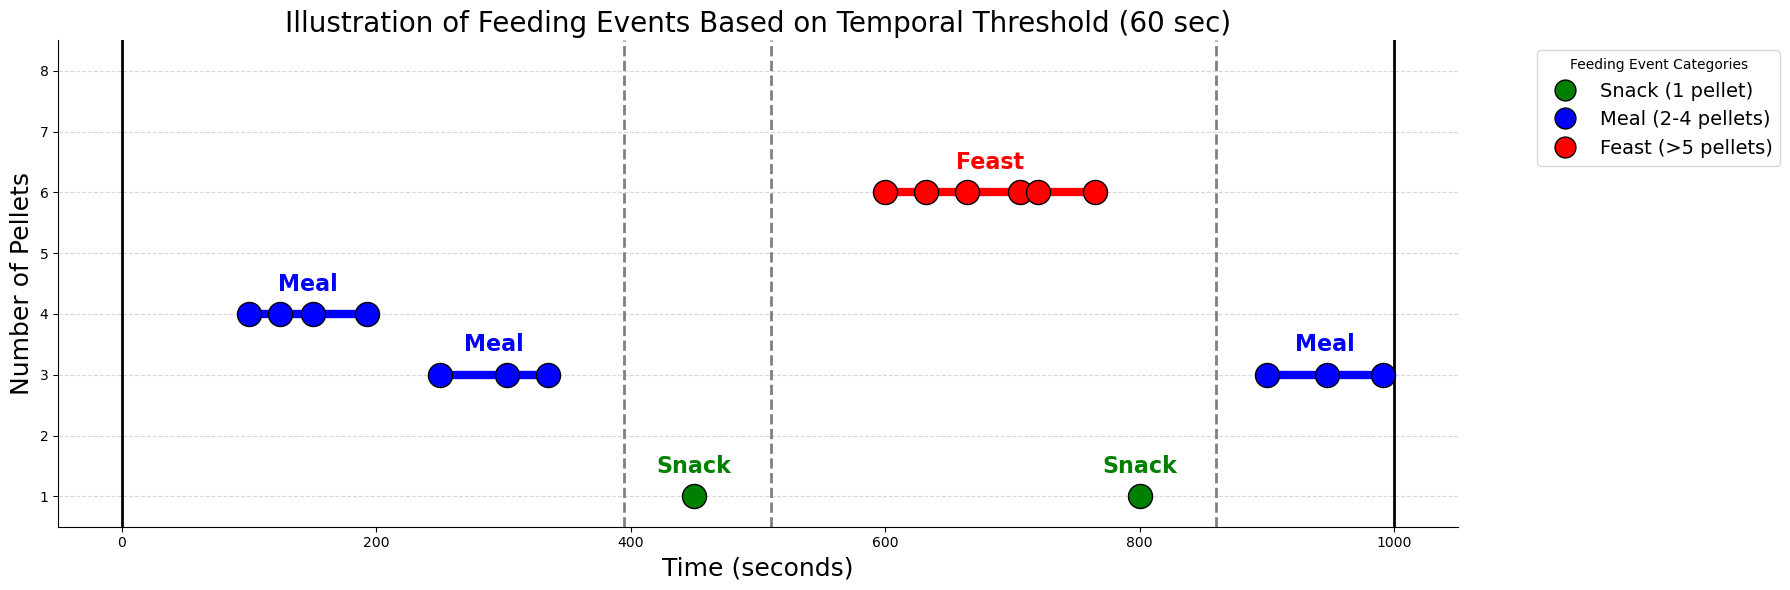

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random

# -----------------------------
# 1. Define Feeding Events Data
# -----------------------------

# IPI threshold in seconds
ipi_threshold = 60  # 60 seconds

# Define feeding events: list of tuples (pellet_times_in_seconds, category)
# Each feeding event will have pellets randomly distributed within the IPI threshold
# and a 60-second gap after the last pellet before the next feeding event.

# Example:
# - Meal 1: 4 pellets at [100, 115, 125, 170] sec (random intervals within 60 sec)
# - Meal 2: 3 pellets at [250, 300, 340] sec
# - Snack 1: 1 pellet at [450] sec

# To ensure random distribution within the IPI threshold, we'll generate pellet times accordingly.

feeding_events = [
    (['Meal', 100, 115, 125, 170]),   # Meal 1: 4 pellets
    (['Meal', 250, 270, 290]),        # Meal 2: 3 pellets
    (['Snack', 450]),                  # Snack 1: 1 pellet
    (['Feast', 600, 620, 640, 660, 680, 700]),  # Feast 1: 6 pellets
    (['Snack', 800]),                  # Snack 2: 1 pellet
    (['Meal', 900, 930, 960]),         # Meal 3: 3 pellets
]

# Function to generate feeding event pellet times with random intervals within IPI threshold
def generate_pellet_times(base_time, pellet_count, ipi_threshold):
    """
    Generates a list of pellet times starting from base_time with random intervals <= ipi_threshold.
    
    Parameters:
    - base_time (int/float): Starting time in seconds.
    - pellet_count (int): Number of pellets in the feeding event.
    - ipi_threshold (int/float): Maximum allowed interval between pellets in seconds.
    
    Returns:
    - List of pellet times in seconds.
    """
    pellet_times = [base_time]
    for _ in range(1, pellet_count):
        # Generate a random interval between 10 and ipi_threshold seconds
        interval = random.randint(10, ipi_threshold)
        next_time = pellet_times[-1] + interval
        pellet_times.append(next_time)
    return pellet_times

# Process feeding events to generate pellet times
processed_feeding_events = []
current_time = 0

for event in feeding_events:
    category = event[0]
    pellet_count = len(event) - 1  # First element is category
    # Generate random pellet times
    if pellet_count > 0:
        base_time = event[1]
        pellets = generate_pellet_times(base_time, pellet_count, ipi_threshold)
    else:
        pellets = []
    processed_feeding_events.append((category, pellets))
    # Set the base_time for the next event ensuring a gap > ipi_threshold
    if pellet_count > 0:
        last_pellet = pellets[-1]
        # Next event starts after last_pellet + ipi_threshold + random_gap (e.g., 60-120 seconds)
        random_gap = random.randint(60, 120)
        current_time = last_pellet + ipi_threshold + random_gap

# -----------------------------
# 2. Plotting the Visualization
# -----------------------------

def plot_feeding_events(processed_feeding_events, ipi_threshold, time_window_end=1000):
    """
    Plots feeding events based on temporal threshold.
    
    Parameters:
    - processed_feeding_events: list of tuples, each containing (category, list of pellet times)
    - ipi_threshold: int/float, inter-pellet interval threshold in seconds
    - time_window_end: int/float, end time of the time window in seconds
    """
    plt.figure(figsize=(18, 6))
    
    # Define color mapping
    category_colors = {'Snack': 'green', 'Meal': 'blue', 'Feast': 'red'}
    
    # To keep track of the previous group's last pellet time
    previous_last_pellet = None
    
    for idx, (category, pellet_times) in enumerate(processed_feeding_events):
        pellet_count = len(pellet_times)
        y = pellet_count  # y-axis represents number of pellets
        
        # Assign color based on category
        color = category_colors.get(category, 'gray')
        
        # Plot each pellet
        for pellet_time in pellet_times:
            plt.scatter(pellet_time, y, color=color, s=300, edgecolors='k', zorder=5)
        
        # Draw a horizontal line connecting pellets in the same group
        if pellet_count > 1:
            plt.hlines(y, min(pellet_times), max(pellet_times), colors=color, linestyles='solid', linewidth=6)
        
        # If not the first group, check gap and draw a vertical dashed line
        if previous_last_pellet is not None:
            gap = pellet_times[0] - previous_last_pellet
            if gap > ipi_threshold:
                # Position the dashed line at previous_last_pellet + ipi_threshold
                dashed_line_x = previous_last_pellet + ipi_threshold
                plt.axvline(x=dashed_line_x, color='gray', linestyle='dashed', linewidth=2)
        
        # Add annotation for the group
        if pellet_count > 1:
            group_center = (min(pellet_times) + max(pellet_times)) / 2
        else:
            group_center = pellet_times[0]
        plt.text(group_center, y + 0.3, category, ha='center', va='bottom', fontsize=16, color=color, fontweight='bold')
        
        # Update the previous_last_pellet
        if pellet_count > 0:
            previous_last_pellet = pellet_times[-1]
    
    # Draw vertical dashed line for the final gap (60 seconds of inactivity)
    if previous_last_pellet is not None:
        final_gap_start = previous_last_pellet
        final_gap_end = final_gap_start + ipi_threshold
        plt.axvline(x=final_gap_end, color='gray', linestyle='dashed', linewidth=2)
    
    # Add vertical lines for the start and end of the time window
    time_window_start = 0
    plt.axvline(x=time_window_start, color='black', linestyle='-', linewidth=2)
    plt.axvline(x=time_window_end, color='black', linestyle='-', linewidth=2)
    
    # Customize the plot
    plt.yticks(range(1, 9))  # Show y-axis from 1 to 8
    plt.xlabel('Time (seconds)', fontsize=18)
    plt.ylabel('Number of Pellets', fontsize=18)
    plt.title(f'Illustration of Feeding Events Based on Temporal Threshold (60 sec)', fontsize=20)
    plt.xlim(time_window_start - 50, time_window_end + 50)  # Add some padding to the x-axis
    plt.ylim(0.5, 8.5)  # Adjust y-axis limits
    
    # Remove upper and right spines
    sns.despine(top=True, right=True)
    
    # Create a legend
    import matplotlib.lines as mlines
    snack_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                              markersize=15, label='Snack (1 pellet)', markeredgecolor='k')
    meal_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                              markersize=15, label='Meal (2-4 pellets)', markeredgecolor='k')
    feast_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                              markersize=15, label='Feast (>5 pellets)', markeredgecolor='k')
    plt.legend(handles=[snack_marker, meal_marker, feast_marker], title='Feeding Event Categories', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
    
    # Add a horizontal grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Call the plotting function with processed feeding events
plot_feeding_events(processed_feeding_events, ipi_threshold, time_window_end=1000)


C:\Users\hta031\AppData\Local\Temp\ipykernel_56228\3996748496.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('inferno')  # A colormap with many distinct colors


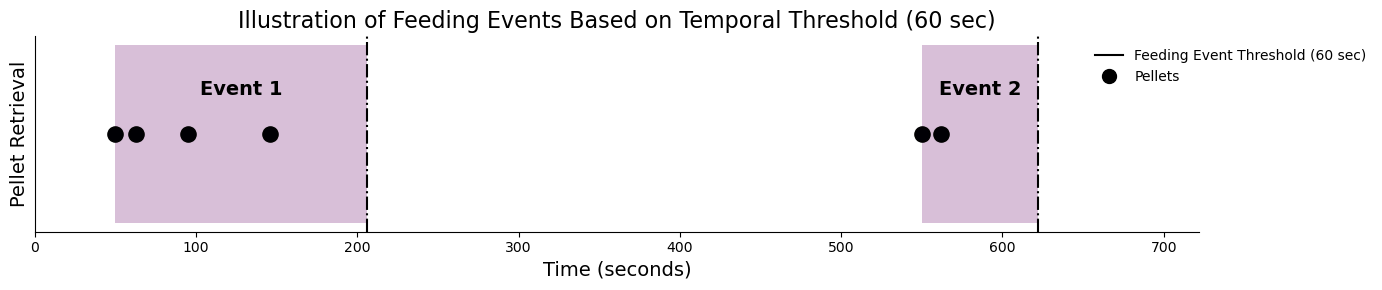

In [102]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# -----------------------------
# 1. Define Pellet Consumption Data
# -----------------------------

# Define feeding events: list of lists, each sublist contains pellet times in seconds
# Three feeding events: 4 pellets, 3 pellets, and 1 pellet
feeding_events = [
    [50, 63, 95, 146],    # Feeding Event 1: 4 pellets with gaps 15, 35, 46 sec
    # [300, 322, 332],       # Feeding Event 2: 3 pellets with gaps 22, 10 sec
    [550,562]                   # Feeding Event 3: 1 pellet
]

# IPI threshold in seconds
ipi_threshold = 60  # 60 seconds

# -----------------------------
# 2. Assign Colors to Feeding Events
# -----------------------------

# Define a color palette
color_palette = plt.cm.get_cmap('inferno')  # A colormap with many distinct colors

# Assign a unique color to each feeding event
event_colors = {i: color_palette(i) for i in range(len(feeding_events))}

# -----------------------------
# 3. Plot the Visualization
# -----------------------------

plt.figure(figsize=(14, 3))  # Wide figure for better timeline visualization

# Plot each feeding event
for event_idx, event in enumerate(feeding_events):
    color = event_colors[event_idx]
    
    # Number of pellets in the event (used for y-axis if needed)
    pellet_count = len(event)
    y = 1  # Keeping y=1 as per your original code
    
    # Plot pellets as large colored dots with black edges for visibility
    plt.scatter(event, [y]*len(event), color=color, s=120, edgecolors='k', zorder=2)
    
    # Define start and end times of the feeding event
    event_start = event[0]
    event_end = event[-1]
    
    # Calculate the position of the dashed line (60 sec after the last pellet)
    dashed_line_x = event_end + ipi_threshold
    
    # Draw a rectangle around the feeding event up to the dashed line
    rect = patches.Rectangle(
        (event_start, 0.75),                   # (x, y) position
        dashed_line_x - event_start,            # Width of the rectangle (end at dashed line)
        0.5,                                    # Height of the rectangle
        linewidth=2,
        edgecolor=color,
        facecolor='thistle',
        linestyle=''
    )
    plt.gca().add_patch(rect)
    
    # Draw vertical dashed line 60 seconds after the last pellet to mark the end of the time window
    plt.axvline(x=dashed_line_x, color='black', linestyle='-.', linewidth=1.5)
    
    # Annotate the feeding event above the pellets
    plt.text(
        (event_start + dashed_line_x) / 2,    # X position (center of the time window)
        y + 0.1,                               # Y position (above the pellets)
        f'Event {event_idx+1}',                # Text label
        ha='center',
        va='bottom',
        fontsize=14,
        color="black",
        fontweight='bold'
    )

# Customize the plot
plt.yticks([])  # Hide y-axis ticks
plt.xlabel('Time (seconds)', fontsize=14)
plt.title(f'Illustration of Feeding Events Based on Temporal Threshold ({ipi_threshold} sec)', fontsize=16)
plt.xlim(0, max([max(event) for event in feeding_events]) + ipi_threshold + 100)  # Add padding to the x-axis
plt.ylabel("Pellet Retrieval", fontsize=14)

# Create a custom line for the feeding event threshold
threshold_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1.5, label='Feeding Event Threshold (60 sec)')

# Create a custom marker for pellets
pellet_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Pellets')

# Add the custom legend to the plot with both threshold and pellets
plt.legend(handles=[threshold_line, pellet_marker], loc='upper left', bbox_to_anchor=(0.9, 1), title='', frameon=False)


# Remove upper and right spines for a cleaner look
sns.despine(top=True, right=True)


plt.tight_layout()
plt.show()


C:\Users\hta031\AppData\Local\Temp\ipykernel_56228\4157686537.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('inferno')  # A colormap with many distinct colors


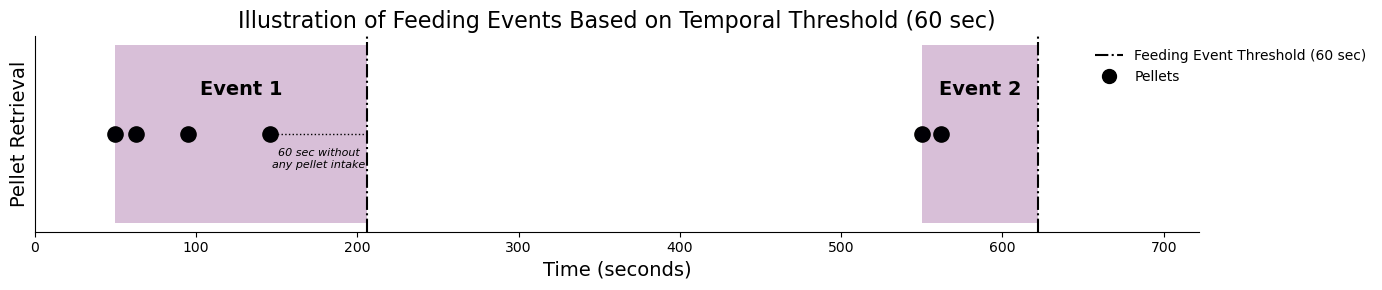

In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.lines as mlines  # Import for custom legend entries

# -----------------------------
# 1. Define Pellet Consumption Data
# -----------------------------

# Define feeding events: list of lists, each sublist contains pellet times in seconds
# Three feeding events: 4 pellets, and 2 pellet
feeding_events = [
    [50, 63, 95, 146],    # Feeding Event 1: 4 pellets with gaps
   
    [550, 562]             # Feeding Event 3: 2 pellet
]

# IPI threshold in seconds
ipi_threshold = 60  # 60 seconds

# -----------------------------
# 2. Assign Colors to Feeding Events
# -----------------------------

# Define a color palette
color_palette = plt.cm.get_cmap('inferno')  # A colormap with many distinct colors

# Assign a unique color to each feeding event
event_colors = {i: color_palette(i) for i in range(len(feeding_events))}

# -----------------------------
# 3. Plot the Visualization
# -----------------------------

plt.figure(figsize=(14, 3))  # Wide figure for better timeline visualization

# Plot each feeding event
for event_idx, event in enumerate(feeding_events):
    color = event_colors[event_idx]
    
    # Number of pellets in the event (used for y-axis if needed)
    pellet_count = len(event)
    y = 1  # Keeping y=1 as per your original code
    
    # Plot pellets as large colored dots with black edges for visibility
    plt.scatter(event, [y]*len(event), color=color, s=120, edgecolors='k', zorder=2)
    
    # Define start and end times of the feeding event
    event_start = event[0]
    event_end = event[-1]
    
    # Calculate the position of the dashed line (60 sec after the last pellet)
    dashed_line_x = event_end + ipi_threshold
    
    # Draw a rectangle around the feeding event up to the dashed line
    rect = patches.Rectangle(
        (event_start, 0.75),                   # (x, y) position
        dashed_line_x - event_start,            # Width of the rectangle (end at dashed line)
        0.5,                                    # Height of the rectangle
        linewidth=2,
        edgecolor=color,
        facecolor='thistle',
        linestyle=''
    )
    plt.gca().add_patch(rect)
    
    # Draw vertical dashed line 60 seconds after the last pellet to mark the end of the time window
    plt.axvline(x=dashed_line_x, color='black', linestyle='-.', linewidth=1.5)
    
    # Annotate the feeding event above the pellets
    plt.text(
        (event_start + dashed_line_x) / 2,    # X position (center of the time window)
        y + 0.1,                               # Y position (above the pellets)
        f'Event {event_idx+1}',                # Text label
        ha='center',
        va='bottom',
        fontsize=14,
        color="black",
        fontweight='bold'
    )
    
    # -----------------------------
    # 4. Add Annotation for Last Pellet of Event 1
    # -----------------------------
    if event_idx == 0:  # Only for Event 1
        last_pellet_x = event_end
        last_pellet_y = y
        
        # Coordinates for the threshold line
        threshold_x = dashed_line_x
        threshold_y = y
        
        # Draw a dotted horizontal line connecting the last pellet to the threshold line
        plt.plot([last_pellet_x, threshold_x], [last_pellet_y, threshold_y], linestyle=':', color='black', linewidth=1)
        
        # Add annotation text near the line
        plt.text(
            (last_pellet_x + threshold_x) / 2,    # X position (midpoint of the line)
            y - 0.1,                              # Y position (slightly above the line)
            '60 sec without\nany pellet intake',     # Annotation text with newline character
            ha='center',
            va='bottom',
            fontsize=8,
            color='black',
            fontstyle='italic'
        )

# -----------------------------
# 5. Customize the Plot
# -----------------------------

plt.yticks([])  # Hide y-axis ticks
plt.xlabel('Time (seconds)', fontsize=14)
plt.title(f'Illustration of Feeding Events Based on Temporal Threshold ({ipi_threshold} sec)', fontsize=16)
plt.xlim(0, max([max(event) for event in feeding_events]) + ipi_threshold + 100)  # Add padding to the x-axis
plt.ylabel("Pellet Retrieval", fontsize=14)

# Create a custom line for the feeding event threshold
threshold_line = mlines.Line2D([], [], color='black', linestyle='-.', linewidth=1.5, label='Feeding Event Threshold (60 sec)')

# Create a custom marker for pellets
pellet_marker = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Pellets')

# Add the custom legend to the plot with both threshold and pellets
plt.legend(handles=[threshold_line, pellet_marker], loc='upper left', bbox_to_anchor=(0.9, 1), title='', frameon=False)

# Remove upper and right spines for a cleaner look
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()
